# Clustering Airports by Delays

In [73]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import psycopg2 as psy
import seaborn as sns
import unicodedata as ucd
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sqlalchemy import create_engine
from sklearn import cluster, metrics
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA 
%matplotlib inline
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### Examining the data 

In [74]:
airports = pd.read_csv('assets/airports.csv', encoding='utf-8')
airport_canc = pd.read_csv('assets/airport_cancellations.csv', encoding='utf-8')
airport_ops = pd.read_csv('assets/Airport_operations.csv', encoding='utf-8')

#### AIRPORTS_DF

In [75]:
# To avoid sql merging problems - lowercasing all column names and replacing blank spaces with underscores:
airports.columns = [x.lower() for x in airports.columns]
airports.columns = [x.strip().replace(' ', '_') for x in airports.columns]
airports = airports[airports.locid.notnull()] 
airports = airports[airports.key.notnull()] 

In [76]:
airports.head()

,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [77]:
airport_canc['Year'].unique()

array([ 2004.,  2005.,  2006.,  2007.,  2008.,  2009.,  2010.,  2011.,
        2012.,  2013.,  2014.])

#### AIRPORTS_CANC DF

In [78]:
# To avoid sql merging problems - lowercasing all column names and replacing blank spaces with underscores:
airport_canc.columns = [x.lower() for x in airport_canc.columns]
airport_canc.columns = [x.strip().replace(' ', '_') for x in airport_canc.columns]

In [79]:
airport_canc.head()

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [80]:
#Clean airport_canc data - casting all columns but the first as int types:
def change_to_int(df):  
    thelist = df.columns
    for item in thelist[1:]:
        try:
            df[item] = df[item].astype(int)
        except:
            pass

change_to_int(airport_canc)

In [81]:
#Scale airport_canc dataframe
airport_canc_list = ['year', 'departure_cancellations',\
                     'arrival_cancellations', 'departure_diversions', 'arrival_diversions']
mms = MinMaxScaler()
for column in airport_canc_list:
    airport_canc[column] = mms.fit_transform(airport_canc[column].astype(float).reshape(-1, 1))

airport_canc.head()

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
0,ABQ,0.0,0.014563,0.013374,0.066729,0.023614
1,ABQ,0.1,0.013299,0.010813,0.057331,0.016940
2,ABQ,0.2,0.023589,0.018724,0.066729,0.063655
3,ABQ,0.3,0.022024,0.017301,0.100564,0.023101
4,ABQ,0.4,0.020039,0.017074,0.074248,0.021561


In [82]:
airport_canc.describe()

,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
count,805.000000,805.000000,805.000000,805.000000,805.000000
mean,0.498634,0.077749,0.075871,0.162891,0.086968
std,0.315812,0.110480,0.112414,0.161979,0.117311
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.021001,0.017870,0.058271,0.021047
50%,0.500000,0.039896,0.036537,0.103383,0.043121
75%,0.800000,0.088579,0.086677,0.221805,0.097536
max,1.000000,1.000000,1.000000,1.000000,1.000000


#### AIRPORT_OPS

In [83]:
# To avoid sql merging problems - lowercasing all column names and replacing blank spaces with underscores:
airport_ops.columns = [x.lower() for x in airport_ops.columns]
airport_ops.columns = [x.strip().replace(' ', '_') for x in airport_ops.columns]

In [84]:
#Standardizing airport_ops
a_o_column_list = ['year', 'departures_for_metric_computation',
       'arrivals_for_metric_computation', 'percent_on-time_gate_departures',
       'percent_on-time_airport_departures', 'percent_on-time_gate_arrivals',
       'average_gate_departure_delay', 'average_taxi_out_time',
       'average_taxi_out_delay', 'average_airport_departure_delay',
       'average_airborne_delay', 'average_taxi_in_delay',
       'average_block_delay', 'average_gate_arrival_delay']

for column in a_o_column_list:
    airport_ops[column] = mms.fit_transform(airport_ops[column].astype(float).reshape(-1, 1))

airport_ops.head()

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,0.0,0.109263,0.110081,0.839065,0.821237,0.841424,0.141890,0.099234,0.128300,0.168016,0.219796,0.134304,0.209857,0.159019
1,ABQ,0.1,0.104906,0.106092,0.855656,0.838576,0.855807,0.119887,0.095752,0.120908,0.141990,0.190684,0.144013,0.176471,0.136953
2,ABQ,0.2,0.100538,0.104698,0.831976,0.813104,0.809960,0.154866,0.099234,0.114044,0.174667,0.170306,0.135922,0.227345,0.192294
3,ABQ,0.3,0.107807,0.109656,0.835294,0.805125,0.792161,0.167560,0.114903,0.126716,0.192597,0.180495,0.208738,0.290938,0.223468
4,ABQ,0.4,0.100349,0.101231,0.850075,0.826607,0.833154,0.153456,0.117340,0.127244,0.174378,0.126638,0.166667,0.248013,0.180385


### Create a PostgreSQL database 

#### Let's create a database where we can house our airport data

In [85]:
%%sql 
postgresql://mikeroman@localhost:5432/airports

u'Connected: mikeroman@airports'

In [86]:
engine = create_engine('postgresql://mikeroman@localhost:5432/airports')
connect = engine.connect()

In [87]:
print(airport_canc.shape)
print(airports.shape)
print(airport_ops.shape)

(805, 6)
(5152, 13)
(841, 15)


Load our csv files into tables

In [88]:
airports.to_sql('airports', engine, if_exists='replace')
airport_canc.to_sql('cancellations', engine, if_exists='replace')
airport_ops.to_sql('operations', engine, if_exists='replace')

Join airport_cancellations.csv and airports.csv into one table

In [89]:
%%sql
SELECT * FROM airports LIMIT 5

5 rows affected.


index,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,None,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.01933,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [90]:
%%sql
ALTER TABLE airports RENAME COLUMN index TO ap_index;

Done.


[]

In [91]:
%%sql
CREATE TABLE airports_and_cancellations AS 
SELECT * from airports 
FULL JOIN cancellations
ON airports.locid = cancellations.airport;    

(psycopg2.ProgrammingError) relation "airports_and_cancellations" already exists
 [SQL: 'CREATE TABLE airports_and_cancellations AS \nSELECT * from airports \nFULL JOIN cancellations\nON airports.locid = cancellations.airport;']


In [92]:
%%sql
ALTER TABLE operations RENAME COLUMN year TO op_year;
ALTER TABLE operations RENAME COLUMN airport TO airport_code;
ALTER TABLE operations RENAME COLUMN index TO op_index;

Done.
Done.
Done.


[]

In [93]:
%%sql
CREATE TABLE all_tables_combined AS 
SELECT * FROM airports_and_cancellations
JOIN operations
ON (airports_and_cancellations.airport = operations.airport_code
AND airports_and_cancellations.year = operations.op_year);   

(psycopg2.ProgrammingError) relation "all_tables_combined" already exists
 [SQL: 'CREATE TABLE all_tables_combined AS \nSELECT * FROM airports_and_cancellations\nJOIN operations\nON (airports_and_cancellations.airport = operations.airport_code\nAND airports_and_cancellations.year = operations.op_year);']


Query the database for our intial data

In [94]:
%%sql
SELECT * FROM airports_and_cancellations LIMIT 15;

15 rows affected.


ap_index,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available,index,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions
2557,5083.0,00A,TOTAL RF,None,Airport,AEA,BUCKS,BENSALEM,PA,Public Use,40.070833,-74.933611,No,None,None,None,None,None,None,None
1791,692.0,00C,ANIMAS AIR PARK,Animas Air Park,Airport,ANM,LA PLATA,DURANGO,CO,Public Use,37.203178,-107.869195,Yes,None,None,None,None,None,None,None
4187,2022.0,00F,BROADUS,Broadus Airport,Airport,ANM,POWDER RIVER,BROADUS,MT,Public Use,45.470472,-105.457139,Yes,None,None,None,None,None,None,None
515,4674.0,00M,THIGPEN FIELD,None,Airport,ASO,JASPER,BAY SPRINGS,MS,Public Use,31.95375,-89.235333,No,None,None,None,None,None,None,None
2361,4817.0,00N,BUCKS,None,Airport,AEA,CUMBERLAND,BRIDGETON,NJ,Public Use,39.473028,-75.184417,No,None,None,None,None,None,None,None
335,3237.0,00R,LIVINGSTON MUNI,Livingston Municipal Airport,Airport,ASW,POLK,LIVINGSTON,TX,Public Use,30.685861,-95.017917,Yes,None,None,None,None,None,None,None
3887,2764.0,00S,MC KENZIE BRIDGE STATE,Mckenzie Bridge State Airport,Airport,ANM,LANE,MC KENZIE BRIDGE,OR,Public Use,44.181556,-122.085556,Yes,None,None,None,None,None,None,None
4417,3495.0,00W,LOWER GRANITE STATE,Lower Granite State Airport,Airport,ANM,WHITMAN,COLFAX,WA,Public Use,46.67275,-117.441667,Yes,None,None,None,None,None,None,None
5047,3955.0,01A,PURKEYPILE,None,Airport,AAL,KUSKOKWIM,PURKEYPILE,AK,Public Use,62.943611,-152.270016,No,None,None,None,None,None,None,None
3001,4361.0,01B,TIPPECANOE,None,Airport,AGL,KOSCIUSKO,WARSAW,IN,Public Use,41.333056,-85.7675,No,None,None,None,None,None,None,None


In [95]:
%%sql
SELECT * FROM all_tables_combined LIMIT 15;

15 rows affected.


ap_index,key,locid,ap_name,alias,facility_type,faa_region,county,city,state,ap_type,latitude,longitude,boundary_data_available,index,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,op_index,airport_code,op_year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,0,ABQ,0.0,0.0145625225659,0.0133743099425,0.0667293233083,0.023613963039,0,ABQ,0.0,0.109263271388,0.110081391047,0.839064856712,0.821236765383,0.84142394822,0.141889985896,0.0992339832869,0.128299894403,0.168016194332,0.219796215429,0.13430420712,0.209856915739,0.159019264448
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,1,ABQ,0.1,0.0132988325912,0.0108132718684,0.0573308270677,0.0169404517454,1,ABQ,0.1,0.104905760174,0.106091996547,0.855656108597,0.838576031917,0.855807263574,0.119887165021,0.0957520891365,0.12090813094,0.141989589358,0.190684133916,0.144012944984,0.176470588235,0.136952714536
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,2,ABQ,0.2,0.0235888795282,0.0187240339195,0.0667293233083,0.0636550308008,2,ABQ,0.2,0.100538077365,0.104698483167,0.83197586727,0.813104189044,0.809960445883,0.154866008463,0.0992339832869,0.114044350581,0.174667437825,0.170305676856,0.135922330097,0.227344992051,0.192294220665
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,3,ABQ,0.3,0.0220243109881,0.0173012349895,0.100563909774,0.0231006160164,3,ABQ,0.3,0.107806699012,0.109655937847,0.835294117647,0.805125057542,0.792161093132,0.167559943583,0.114902506964,0.12671594509,0.192596876807,0.180494905386,0.208737864078,0.29093799682,0.223467600701
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,4,ABQ,0.4,0.0200385124564,0.0170735871607,0.0742481203008,0.0215605749487,4,ABQ,0.4,0.100348885702,0.101231142352,0.850075414781,0.826607334663,0.833153541891,0.153455571227,0.117339832869,0.127243928194,0.174378253326,0.126637554585,0.166666666667,0.248012718601,0.180385288967
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,5,ABQ,0.5,0.0115537369118,0.00921973706676,0.0695488721805,0.0133470225873,5,ABQ,0.5,0.0860293145362,0.087238459325,0.885972850679,0.873101120147,0.895900755124,0.109732016925,0.0988857938719,0.0997888067582,0.12030075188,0.11499272198,0.148867313916,0.119236883943,0.102977232925
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,6,ABQ,0.6,0.0133590083042,0.0100734164248,0.0667293233083,0.0256673511294,6,ABQ,0.6,0.0855248034339,0.0861388580589,0.856259426848,0.836274359368,0.864077669903,0.138222849083,0.101323119777,0.108236536431,0.152978600347,0.103347889374,0.153721682848,0.106518282989,0.136602451839
1223,2348.0,ABQ,ALBUQUERQUE INTL SUNPORT,Albuquerque Int'l Sunport,Airport,ASW,BERNALILLO,ALBUQUERQUE,NM,Federalized/Commercial,35.040194,-106.609194,Yes,7,ABQ,0.7,0.0207606210134,0.0167321154174,0.0723684210526,0.0313141683778,7,ABQ,0.7,0.0854861513737,0.086401940231,0.845399698341,0.813411078717,0.859582883855,0.154019746121,0.120473537604,0.1

### Exploratory Data Analysis

#### Plot and Describe the Data

In [96]:
airports_and_cancellations = pd.read_sql_query('SELECT * FROM "airports_and_cancellations"',con=engine)
all_tables_combined = pd.read_sql_query('SELECT * FROM "all_tables_combined"',con=engine)

In [97]:
df = all_tables_combined.drop(['faa_region','ap_index','airport_code','key','locid','op_index','op_year','ap_name','alias','county', 'city', 'state','facility_type','ap_type','latitude','longitude','boundary_data_available','index'], 1)

In [98]:
df.head()

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,0.0,0.014563,0.013374,0.066729,0.023614,0.109263,0.110081,0.839065,0.821237,0.841424,0.141890,0.099234,0.128300,0.168016,0.219796,0.134304,0.209857,0.159019
1,ABQ,0.1,0.013299,0.010813,0.057331,0.016940,0.104906,0.106092,0.855656,0.838576,0.855807,0.119887,0.095752,0.120908,0.141990,0.190684,0.144013,0.176471,0.136953
2,ABQ,0.2,0.023589,0.018724,0.066729,0.063655,0.100538,0.104698,0.831976,0.813104,0.809960,0.154866,0.099234,0.114044,0.174667,0.170306,0.135922,0.227345,0.192294
3,ABQ,0.3,0.022024,0.017301,0.100564,0.023101,0.107807,0.109656,0.835294,0.805125,0.792161,0.167560,0.114903,0.126716,0.192597,0.180495,0.208738,0.290938,0.223468
4,ABQ,0.4,0.020039,0.017074,0.074248,0.021561,0.100349,0.101231,0.850075,0.826607,0.833154,0.153456,0.117340,0.127244,0.174378,0.126638,0.166667,0.248013,0.180385


In [99]:
#going to work with all tables combined and drop columns we don't need:
#df['airport'] = LabelEncoder().fit_transform(df['airport'])
#df['airport'] = MinMaxScaler().fit_transform(df['airport'].astype(float).reshape(-1, 1))

In [100]:
df.head()

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,0.0,0.014563,0.013374,0.066729,0.023614,0.109263,0.110081,0.839065,0.821237,0.841424,0.141890,0.099234,0.128300,0.168016,0.219796,0.134304,0.209857,0.159019
1,ABQ,0.1,0.013299,0.010813,0.057331,0.016940,0.104906,0.106092,0.855656,0.838576,0.855807,0.119887,0.095752,0.120908,0.141990,0.190684,0.144013,0.176471,0.136953
2,ABQ,0.2,0.023589,0.018724,0.066729,0.063655,0.100538,0.104698,0.831976,0.813104,0.809960,0.154866,0.099234,0.114044,0.174667,0.170306,0.135922,0.227345,0.192294
3,ABQ,0.3,0.022024,0.017301,0.100564,0.023101,0.107807,0.109656,0.835294,0.805125,0.792161,0.167560,0.114903,0.126716,0.192597,0.180495,0.208738,0.290938,0.223468
4,ABQ,0.4,0.020039,0.017074,0.074248,0.021561,0.100349,0.101231,0.850075,0.826607,0.833154,0.153456,0.117340,0.127244,0.174378,0.126638,0.166667,0.248013,0.180385


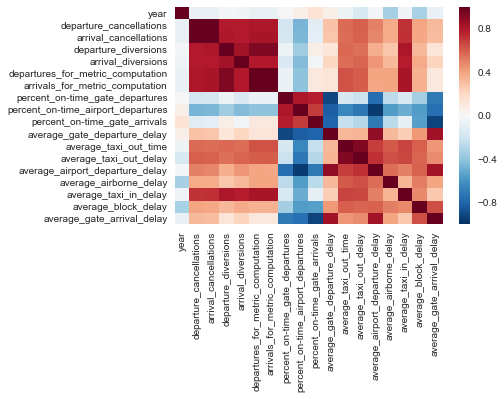

In [101]:
sns.heatmap(df.corr());

In [102]:
# There are some very skewed features in our dataframe. It seems that the majority of airports tend to operate
# well, however, the ones that perform poorly significantly underperform the rest.

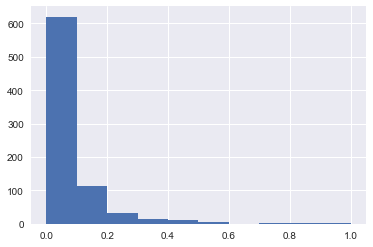

In [103]:
df['arrival_cancellations'].hist();

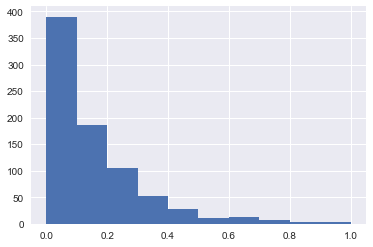

In [104]:
df['departure_diversions'].hist();

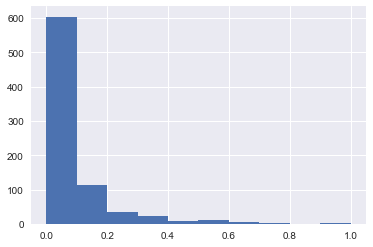

In [105]:
df['arrival_diversions'].hist();

### PCA

In [106]:
df.head()

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,0.0,0.014563,0.013374,0.066729,0.023614,0.109263,0.110081,0.839065,0.821237,0.841424,0.141890,0.099234,0.128300,0.168016,0.219796,0.134304,0.209857,0.159019
1,ABQ,0.1,0.013299,0.010813,0.057331,0.016940,0.104906,0.106092,0.855656,0.838576,0.855807,0.119887,0.095752,0.120908,0.141990,0.190684,0.144013,0.176471,0.136953
2,ABQ,0.2,0.023589,0.018724,0.066729,0.063655,0.100538,0.104698,0.831976,0.813104,0.809960,0.154866,0.099234,0.114044,0.174667,0.170306,0.135922,0.227345,0.192294
3,ABQ,0.3,0.022024,0.017301,0.100564,0.023101,0.107807,0.109656,0.835294,0.805125,0.792161,0.167560,0.114903,0.126716,0.192597,0.180495,0.208738,0.290938,0.223468
4,ABQ,0.4,0.020039,0.017074,0.074248,0.021561,0.100349,0.101231,0.850075,0.826607,0.833154,0.153456,0.117340,0.127244,0.174378,0.126638,0.166667,0.248013,0.180385


In [107]:
X = df.iloc[:,2:].as_matrix(columns=None)
y = df.ix[:,0]

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


In [108]:
covMat1 = np.cov(X.T)
eigenValues, eigenVectors = np.linalg.eig(covMat1)

In [109]:
print(eigenValues)

[  1.88015326e-01   6.22636726e-02   2.11669062e-02   1.31106818e-02
   9.76328144e-03   6.65403683e-03   4.47140846e-03   3.08154878e-03
   2.65557337e-03   1.69672397e-03   1.28290010e-03   8.05779519e-04
   1.62751058e-04   4.82032059e-05   2.04060015e-05   1.10811076e-05
   6.80691889e-06]


In [110]:
print(eigenVectors)

[[ -2.18780741e-01   6.41470739e-02   1.31229418e-01  -5.51844458e-02
    1.76075705e-01   5.47266580e-01   1.47516974e-01   2.36980162e-01
    8.78964586e-02  -4.54367802e-02   7.34362815e-02   6.75447762e-02
   -4.65292469e-02  -1.04295065e-01  -6.96118780e-01  -3.92636061e-02
   -2.04584522e-02]
 [ -2.23422528e-01   7.75575778e-02   1.34825698e-01  -5.36207394e-02
    1.86103581e-01   5.26883125e-01   1.56223280e-01   2.34563643e-01
    7.32242160e-02  -7.58556464e-02   1.09487219e-01   9.69267676e-02
    2.64353687e-02   1.27647967e-01   6.93057886e-01   3.46190069e-02
    1.81439232e-02]
 [ -3.28695479e-01   2.46123939e-01   1.52437897e-01   3.33363916e-02
    4.68104470e-02  -7.79671335e-02  -6.31389658e-02  -4.77774328e-01
   -3.31782124e-01  -4.26687501e-01   5.22748578e-01   9.04271658e-04
    2.64207120e-03   4.38162633e-04  -3.26893814e-02   1.73872711e-03
    4.63090742e-03]
 [ -2.26264416e-01   1.00521005e-01   1.26203487e-01   2.70061083e-02
    2.24379004e-02   2.6629372

In [111]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

0.188015326329
0.0622636725739
0.0211669061843
0.0131106817523
0.00976328144332
0.00665403683048
0.00447140846107
0.00308154877808
0.00265557337459
0.00169672396659
0.00128290009561
0.000805779519035
0.000162751058444
4.82032059091e-05
2.04060015145e-05
1.10811076359e-05
6.80691889027e-06


In [112]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [113]:
print(varExpl)

[59.646298923725482, 19.752632399421017, 6.7150249833903217, 4.1592547701391096, 3.0973198558600119, 2.1109378559151857, 1.4185171543534709, 0.97759572665886452, 0.84245857190258266, 0.5382715700787728, 0.40698938797337769, 0.2556268523282576, 0.051631420010575288, 0.015292066263276454, 0.0064736343038367134, 0.0035153892576903901, 0.0021594384181625745]


In [114]:
cvarex = np.cumsum(varExpl)

In [115]:
#Principal Components
print(cvarex)

[ 59.64629892  79.39893132  86.11395631  90.27321108  93.37053093
  95.48146879  96.89998594  97.87758167  98.72004024  99.25831181
  99.6653012   99.92092805  99.97255947  99.98785154  99.99432517
  99.99784056 100.        ]


### Let's see how our clusters look with 2 Principal Components

In [116]:
from sklearn.cluster import KMeans
PCA_set = PCA(n_components=2) # "See the eigenvectors"
Xpc2 = PCA_set.fit_transform(X) # "Using the eigenvectors to transform X onto new axes"
clusters = KMeans().fit_predict(Xpc2)

In [117]:
dfPC2D = pd.DataFrame(Xpc2, columns=['PC1','PC2'])

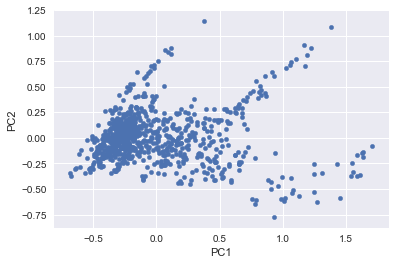

In [118]:
dfPC2D.plot(kind='scatter',x='PC1',y='PC2');

In [119]:
silhouette_score(Xpc2, clusters)

0.39670042062721578

### Let's see how our clusters look with 3 Principal Components (I won't be using this for analysis, just wanted to visualize this to see if the data was very separable in this extra dimension)

In [120]:
PCA_set = PCA(n_components=3) # "See the eigenvectors"
Xpc3 = PCA_set.fit_transform(X) # "Using the eigenvectors to transform X onto new axes"
kmeans = KMeans(n_clusters=2)
clusters3 = kmeans.fit_predict(Xpc3)

In [121]:
dfPC3d = pd.DataFrame(Xpc3, columns=['PC1','PC2','PC3'])

In [122]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

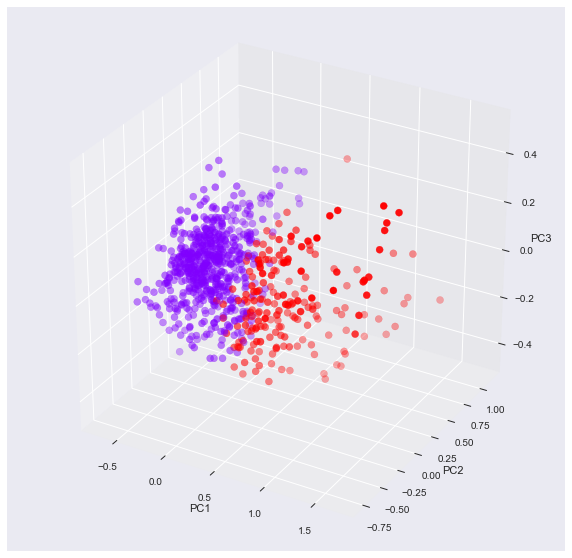

In [123]:
threedee = plt.figure(figsize=(10,10)).gca(projection='3d')
threedee.scatter(dfPC3d['PC1'], dfPC3d['PC2'], dfPC3d['PC3'], c=clusters3, s=50, cmap='rainbow')
threedee.set_xlabel('PC1')
threedee.set_ylabel('PC2')
threedee.set_zlabel('PC3')
plt.show()

In [124]:
silhouette_score(Xpc3, clusters)

0.31088971465878362

### K Means

In [125]:
k = 2
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(Xpc2)
centroids = kmeans.cluster_centers_

In [319]:
Xpc2A = pd.DataFrame(Xpc2, columns = ['PC1', 'PC2'])
Xpc2A['cluster'] = kmeans.labels_

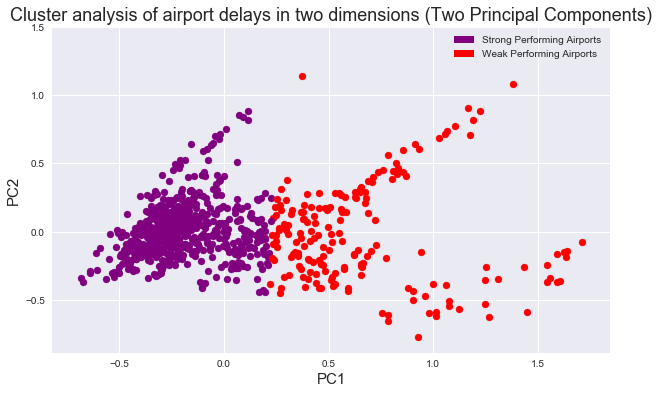

In [363]:
# Back to our two dimensional data - two components only. 
fig, ax = plt.subplots(figsize=(10,6))

for x, y, z in zip(Xpc2A['PC1'].values, Xpc2A['PC2'].values, Xpc2A['cluster']):
    z = [z]
    plt.scatter(x,y, c =['purple' if val == 0 else 'r' for val in z])
ax.set_xticks([-.5,0,.5,1,1.5]);
ax.set_yticks([-.5,0,.5,1,1.5]);
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size =15)
ax.set_title("Cluster analysis of airport delays in two dimensions (Two Principal Components)", size=18)

classes = ["Strong Performing Airports","Weak Performing Airports"]
class_colours = ['purple', 'red']
recs = []
for i in range(0, len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs, classes);

# ax.scatter(centroids[:, 0], centroids[:, 1],
#             marker='x', s=500, linewidths=5,
#             color='k', zorder=10);

### Cluster analysis

In [127]:
# Adding in our cluster labels to our df
df['Cluster'] = kmeans.labels_

#### To start, let's take a look at the average departure/cancellations performance across our entire df, all 799 rows.

In [82]:
df.describe().loc['mean']

year                                  0.501627
departure_cancellations               0.078187
arrival_cancellations                 0.076323
departure_diversions                  0.163769
arrival_diversions                    0.087401
departures_for_metric_computation     0.230306
arrivals_for_metric_computation       0.231728
percent_on-time_gate_departures       0.803051
percent_on-time_airport_departures    0.738465
percent_on-time_gate_arrivals         0.796052
average_gate_departure_delay          0.212701
average_taxi_out_time                 0.237914
average_taxi_out_delay                0.194472
average_airport_departure_delay       0.272224
average_airborne_delay                0.280281
average_taxi_in_delay                 0.228828
average_block_delay                   0.327635
average_gate_arrival_delay            0.248645
Cluster                               0.234043
Name: mean, dtype: float64

#### Let's see how this compares with airports in cluster 0

In [84]:
# Better than the average. These are the better performing airports
df.groupby('Cluster').agg('mean').loc[0]

year                                  0.512908
departure_cancellations               0.037115
arrival_cancellations                 0.034161
departure_diversions                  0.098219
arrival_diversions                    0.043549
departures_for_metric_computation     0.143286
arrivals_for_metric_computation       0.144204
percent_on-time_gate_departures       0.809404
percent_on-time_airport_departures    0.771833
percent_on-time_gate_arrivals         0.801377
average_gate_departure_delay          0.201516
average_taxi_out_time                 0.185467
average_taxi_out_delay                0.146827
average_airport_departure_delay       0.236405
average_airborne_delay                0.233379
average_taxi_in_delay                 0.170778
average_block_delay                   0.287977
average_gate_arrival_delay            0.230360
Name: 0, dtype: float64

In [143]:
# Which airports are in this cluster and perform better than the average?
# 64 airports in the good cluster.
df[df['Cluster']==0]['airport'].unique()

array([u'ABQ', u'ANC', u'AUS', u'BDL', u'BHM', u'BNA', u'BOS', u'BUF',
       u'BUR', u'BWI', u'CLE', u'CLT', u'CVG', u'DAL', u'DAY', u'DCA',
       u'DTW', u'FLL', u'HNL', u'HOU', u'HPN', u'IAD', u'IND', u'ISP',
       u'JAX', u'LAS', u'LGB', u'MCI', u'MCO', u'MDW', u'MEM', u'MHT',
       u'MIA', u'MKE', u'MSP', u'MSY', u'OAK', u'OGG', u'OMA', u'ONT',
       u'OXR', u'PBI', u'PDX', u'PHX', u'PIT', u'PSP', u'PVD', u'RDU',
       u'RFD', u'RSW', u'SAN', u'SAT', u'SDF', u'SEA', u'SFO', u'SJC',
       u'SJU', u'SLC', u'SMF', u'SNA', u'STL', u'SWF', u'TPA', u'TUS'], dtype=object)

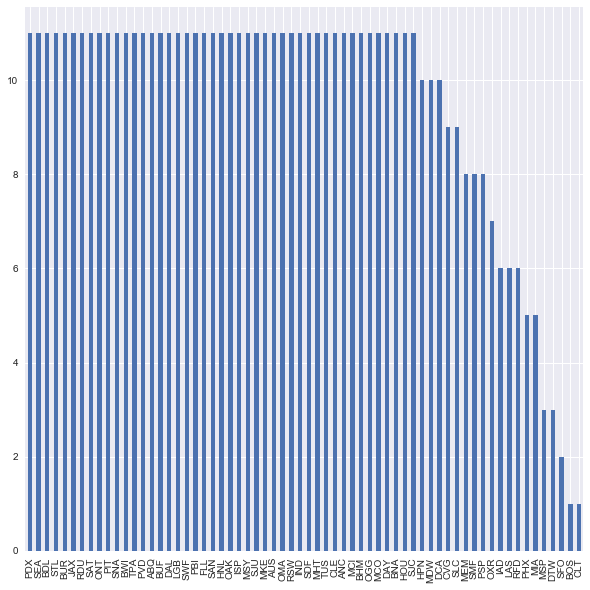

In [145]:
# Let's see how many times each airport appears in cluster 0.
# I want to see if these airports perform outstandingly in all 
# 11 years that I have data or if it's just a flash in the pan:
df[df['Cluster']==0]['airport'].value_counts().plot(kind='bar', figsize=(10,10))

In [186]:
#Let's highlight just those airports that were on the "good list" all
# 11 years. 45 airports in total. 
df[df['Cluster']==0]['airport'].value_counts()[df[df['Cluster']==0]['airport'].value_counts()==11].index

Index([u'PDX', u'SEA', u'BDL', u'STL', u'BUR', u'JAX', u'RDU', u'SAT', u'ONT',
       u'PIT', u'SNA', u'BWI', u'TPA', u'PVD', u'ABQ', u'BUF', u'DAL', u'LGB',
       u'SWF', u'PBI', u'FLL', u'SAN', u'HNL', u'OAK', u'ISP', u'MSY', u'SJU',
       u'MKE', u'AUS', u'OMA', u'RSW', u'IND', u'SDF', u'MHT', u'TUS', u'CLE',
       u'ANC', u'MCI', u'BHM', u'OGG', u'MCO', u'DAY', u'BNA', u'HOU', u'SJC'],
      dtype='object')

In [ ]:
# These always good airports are:
PDX - Portland International Airport
SEA - Seattle Tacoma International Airport
BDL - Bradley International Airport (Connecticut)
STL - St. Louis Lambert International Airport
BUR - Hollywood Burbank Airport
etc...

#### Now let's see how this compares with airports in cluster 1

In [85]:
# We can see here that cluster 1 contains the offending airports.
# These airports perform worse across all metrics available
df.groupby('Cluster').agg('mean').loc[1]

year                                  0.464706
departure_cancellations               0.212607
arrival_cancellations                 0.214306
departure_diversions                  0.378297
arrival_diversions                    0.230916
departures_for_metric_computation     0.515102
arrivals_for_metric_computation       0.518171
percent_on-time_gate_departures       0.782260
percent_on-time_airport_departures    0.629262
percent_on-time_gate_arrivals         0.778624
average_gate_departure_delay          0.249306
average_taxi_out_time                 0.409556
average_taxi_out_delay                0.350400
average_airport_departure_delay       0.389448
average_airborne_delay                0.433778
average_taxi_in_delay                 0.418808
average_block_delay                   0.457428
average_gate_arrival_delay            0.308488
Name: 1, dtype: float64

In [86]:
# Let's see exactly how much worse cluster 1 airports perform 
# versus the average of all airports:
df.groupby('Cluster').agg('mean').loc[1]/df.describe().loc['mean']

year                                  0.926397
departure_cancellations               2.719201
arrival_cancellations                 2.807889
departure_diversions                  2.309941
arrival_diversions                    2.642033
departures_for_metric_computation     2.236594
arrivals_for_metric_computation       2.236116
percent_on-time_gate_departures       0.974110
percent_on-time_airport_departures    0.852121
percent_on-time_gate_arrivals         0.978107
average_gate_departure_delay          1.172098
average_taxi_out_time                 1.721450
average_taxi_out_delay                1.801806
average_airport_departure_delay       1.430616
average_airborne_delay                1.547652
average_taxi_in_delay                 1.830234
average_block_delay                   1.396149
average_gate_arrival_delay            1.240676
Cluster                                    NaN
dtype: float64

In [87]:
# Now, let's see what airports are in the offending cluster!
df[df['Cluster']==1]

,airport,year,departure_cancellations,arrival_cancellations,departure_diversions,arrival_diversions,departures_for_metric_computation,arrivals_for_metric_computation,percent_on-time_gate_departures,percent_on-time_airport_departures,percent_on-time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay,Cluster
22,ATL,0.0,0.473583,0.479939,0.692669,0.396304,0.970496,0.972150,0.773605,0.506368,0.742359,0.232440,0.466922,0.460929,0.435801,0.589520,0.451456,0.550079,0.314536,1
23,ATL,0.1,0.832651,0.824085,0.742481,0.554415,0.985239,0.986377,0.746003,0.576799,0.736426,0.286319,0.399721,0.383316,0.448525,0.478894,0.440129,0.538951,0.381786,1
24,ATL,0.2,0.398604,0.415514,0.858083,0.404004,0.982725,0.983426,0.706335,0.439926,0.712693,0.306065,0.464485,0.508448,0.536726,0.401747,0.668285,0.554849,0.371979,1
25,ATL,0.3,0.408954,0.443344,0.864662,0.536448,1.000000,1.000000,0.708899,0.499616,0.756023,0.322144,0.439763,0.437170,0.517351,0.426492,0.674757,0.508744,0.341856,1
26,ATL,0.4,0.350824,0.381595,0.922932,0.550308,0.981848,0.983204,0.788688,0.554550,0.776339,0.240056,0.472145,0.475713,0.442452,0.459971,0.658576,0.613672,0.328546,1
27,ATL,0.5,0.320375,0.358716,1.000000,0.572895,0.975855,0.977562,0.800603,0.528311,0.736066,0.221439,0.515320,0.513728,0.439271,0.343523,0.768608,0.710652,0.357618,1
28,ATL,0.6,0.493320,0.528086,0.912594,0.485113,0.954667,0.957068,0.828658,0.605800,0.847717,0.210719,0.495125,0.454593,0.393580,0.248908,0.699029,0.387917,0.274256,1
29,ATL,0.7,0.394452,0.425929,0.848684,0.416838,0.924991,0.932041,0.835747,0.655670,0.867853,0.193230,0.462744,0.397043,0.345865,0.212518,0.647249,0.367250,0.218214,1
30,ATL,0.8,0.135937,0.158329,0.750000,0.336242,0.930172,0.936632,0.882805,0.758631,0.931499,0.126657,0.409471,0.318374,0.235685,0.097525,0.506472,0.263911,0.138004,1
31,ATL,0.9,0.175472,0.196346,0.817669,0.336242,0.911210,0.915113,0.822021,0.700936,0.868213,0.195487,0.388579,0.307814,0.309138,0.208151,0.420712,0.383148,0.224518,1


In [190]:
# Which airports are in this cluster and perform worse than the average?
# 25 airports in the bad cluster.
df[df['Cluster']==1]['airport'].unique()

array([u'ATL', u'BOS', u'CLT', u'CVG', u'DCA', u'DEN', u'DFW', u'DTW',
       u'EWR', u'HPN', u'IAD', u'IAH', u'JFK', u'LAS', u'LAX', u'LGA',
       u'MDW', u'MEM', u'MIA', u'MSP', u'ORD', u'PHL', u'PHX', u'SFO',
       u'SLC'], dtype=object)

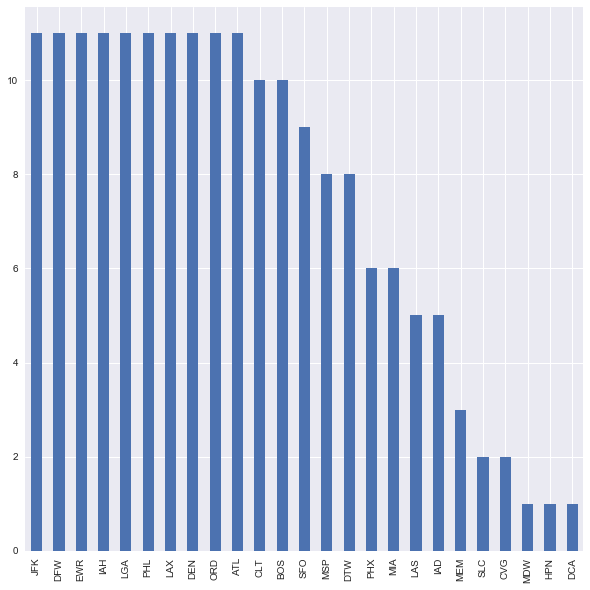

In [191]:
# Let's see how many times each airport appears in cluster 1.
# I want to see if these airports perform poorly in all 
# 11 years that I have data or if it's just a bad year or two:
df[df['Cluster']==1]['airport'].value_counts().plot(kind='bar', figsize=(10,10))

In [193]:
#Let's highlight just those airports that were on the "bad list" all
# 11 years. 10 airports in total. 
df[df['Cluster']==1]['airport'].value_counts()[df[df['Cluster']==1]['airport'].value_counts()==11].index

Index([u'JFK', u'DFW', u'EWR', u'IAH', u'LGA', u'PHL', u'LAX', u'DEN', u'ORD',
       u'ATL'],
      dtype='object')

In [ ]:
# The always bad airports are. 
JFK - John F. Kennedy International Airport (NYC)
DFW - Dallas Fort Worth
EWR - Newark Liberty International Airport
IAH - Houston Bush Airport
LGA - Laguardia Airport (NYC)
PHL - Philadelphia International Airport
LAX - Los Angeles International Airport
DEN - Denver International Airport
ORD - O'Hare International Airport (Chicago)